### Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 
Here I will do some exploratory analysis and evalute tweets from disasters with several NLP methods. 

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from collections import defaultdict
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, Input
from keras.initializers import Constant
from keras.optimizers import Adam


Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
import io
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['test.csv']))
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in train'.format(test_df.shape[0],test_df.shape[1]))

# Dataset is now stored in a Pandas Dataframe

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [0]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
train_df[train_df['target']==0].head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [0]:
train_df[train_df['keyword'].notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [0]:
y_train = train_df['target']

In [0]:
Real_len = train_df[train_df['target'] == 1].shape[0]
Not_len = train_df[train_df['target'] == 0].shape[0]

Text(0.5, 1.0, 'Proportion of real and fake disaster tweets')

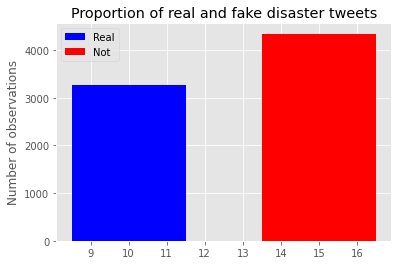

In [0]:
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of observations')
plt.title('Proportion of real and fake disaster tweets')

In [0]:
#Check how long is the longest tweet and plot for real and fake tweets
len_tweet = [len(line) for line in train_df['text']]
train_df['length']=len_tweet

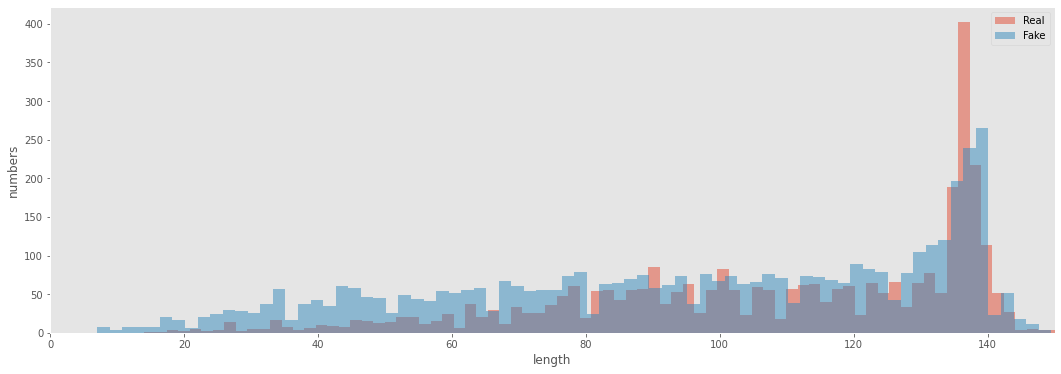

In [0]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.hist(train_df[train_df['target'] == 1]['length'],alpha=0.5, bins=80, label='Real');
plt.hist(train_df[train_df['target'] == 0]['length'],alpha=0.5, bins=80, label='Fake');
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()

In [0]:
#Count the number of words in each tweet in a separated histrogram
words_in_sentence_real = [len(word_tokenize(line)) for line in (train_df[train_df['target']==1]['text'])]
words_in_sentence_fake = [len(word_tokenize(line)) for line in (train_df[train_df['target']==0]['text'])]

Text(0.5, 0.98, 'Words in a tweet')

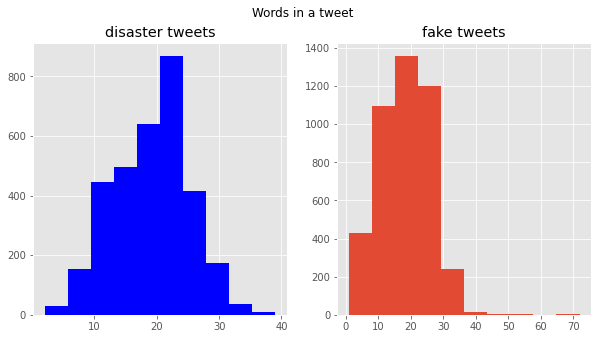

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(words_in_sentence_real, color='b');
ax1.set_title('disaster tweets')

ax2.hist(words_in_sentence_fake);
ax2.set_title('fake tweets')
fig.suptitle('Words in a tweet')


In [0]:
#Which words and punctuations are more common in real and fake disaster tweets

corpus_real_disaster =  [word_tokenize(line) for line in (train_df[train_df['target']==1]['text'])]
corpus_fake_disaster =  [word_tokenize(line) for line in (train_df[train_df['target']==0]['text'])]

In [0]:

dict_common_words_real = defaultdict(int)
dict_common_words_fake = defaultdict(int)
dict_stop_words_real = defaultdict(int)
dict_stop_words_fake = defaultdict(int)
dict_punctuation_real = defaultdict(int)
dict_punctuation_fake = defaultdict(int)

for line in corpus_real_disaster:
    for word in line:
        if word in stop:
            dict_stop_words_real[word]+=1
        elif word in string.punctuation:
            dict_punctuation_real[word]+=1
        else:
            dict_common_words_real[word]+=1 
            
for line in corpus_fake_disaster:
    for word in line:
        if word in stop:
            dict_stop_words_fake[word]+=1
        elif word in string.punctuation:
            dict_punctuation_fake[word]+=1
        else:
            dict_common_words_fake[word]+=1

Text(0.5, 1.0, 'Most common stop words for fake disaster tweets')

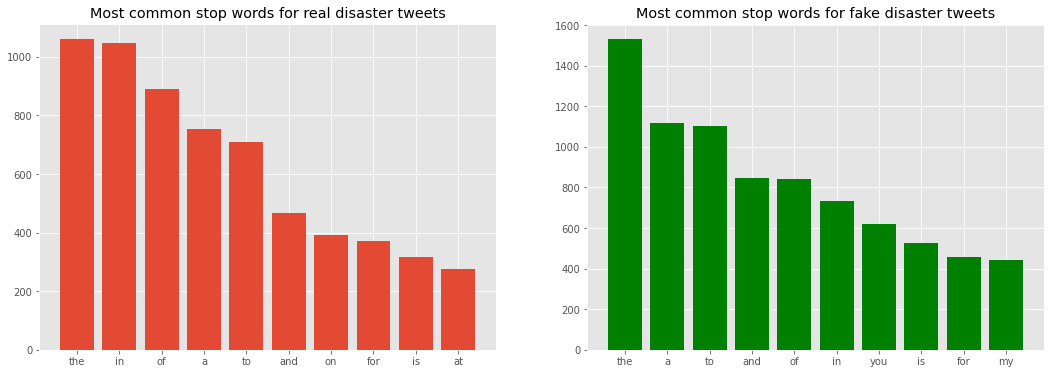

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2)

top_real=sorted(dict_stop_words_real.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top_real)
ax1.bar(x,y);
ax1.set_title('Most common stop words for real disaster tweets')


top_fake=sorted(dict_stop_words_fake.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top_fake)
ax2.bar(x,y, color='g');
ax2.set_title('Most common stop words for fake disaster tweets')


Text(0.5, 1.0, 'Most common punctuation for real disaster tweets')

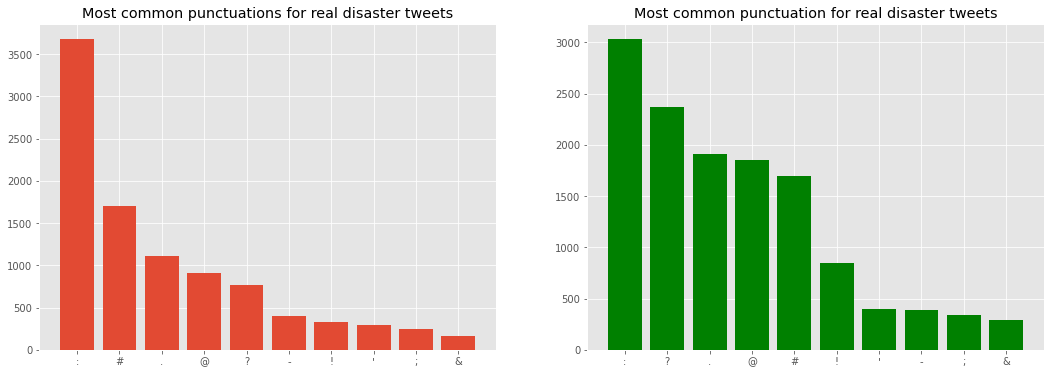

In [0]:
#Let us now analyze punctuation in each type of target
top_punctuations_real = sorted(dict_punctuation_real.items(), key=lambda x:x[1], reverse=True)[:10]

fig,(ax1,ax2)=plt.subplots(1,2)
x,y = zip(*top_punctuations_real)
ax1.bar(x,y)
ax1.set_title('Most common punctuations for real disaster tweets')

top_punctuations_fake = sorted(dict_punctuation_fake.items(), key=lambda x:x[1], reverse=True)[:10]

x,y = zip(*top_punctuations_fake)
ax2.bar(x,y, color='g')
ax2.set_title('Most common punctuation for real disaster tweets')



Text(0.5, 1.0, 'Most common words for fake disaster tweets')

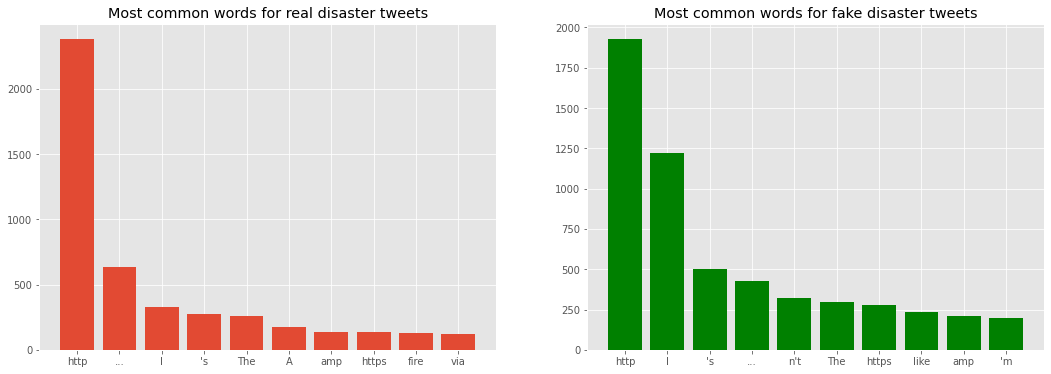

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2)

top_real=sorted(dict_common_words_real.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top_real)
ax1.bar(x,y);
ax1.set_title('Most common words for real disaster tweets')


top_fake=sorted(dict_common_words_fake.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top_fake)
ax2.bar(x,y, color='g');
ax2.set_title('Most common words for fake disaster tweets')

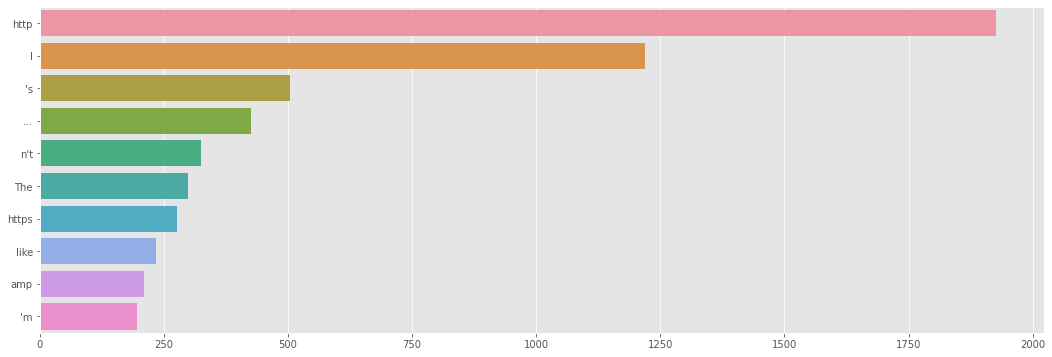

In [0]:
sns.barplot(x=list(y),y=list(x))

### Let us remove punctuation, stop words and not needed prefixes

In [0]:
df=pd.concat([train_df,test_df])
df.shape

(10876, 6)

In [0]:
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88.0


In [0]:
#Remove URL from text
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [0]:
#Remove HTML code from text
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [0]:
#Remove Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [0]:
#Remove punctuation
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
df['text']=df['text'].apply(lambda x: remove_punct(x))

In [0]:
# Dictionary with all abreviations, we will use it to convert words and improve the training phase
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [0]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [0]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [0]:
df['text']=df['text'].apply(lambda x: convert_abbrev_in_text(x))

In [0]:
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,133.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,88.0


In [0]:
X_train = df['text'][:len(train_df)]
X_test = df['text'][len(train_df):]

### Bags of words

In [0]:
count_vectorizer = CountVectorizer()

In [0]:
#There are 21637 unique words in all tweets
train_vector = count_vectorizer.fit_transform(X_train)
train_vector

<7613x17734 sparse matrix of type '<class 'numpy.int64'>'
	with 98387 stored elements in Compressed Sparse Row format>

In [0]:
train_vector[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [0]:
train_vector[0].todense().shape

(1, 17734)

In [0]:
test_vector = count_vectorizer.transform(X_test)

In [0]:
ridge = RidgeClassifier()
scores_ridge = cross_val_score(ridge,train_vector,y_train, scoring='f1', cv=3).mean()
scores_ridge

0.5931079482434293

### TFIDF

In [0]:
#It is still not a very accurate model, let us apply TFIDF to see if it gets better

tf_vector = TfidfVectorizer()
train_vector_tf = tf_vector.fit_transform(X_train)

In [0]:
test_vector_tf = tf_vector.transform(X_test)

In [0]:
scores = cross_val_score(ridge,train_vector_tf,y_train, scoring='f1', cv=3).mean()
scores

0.6296212647055267

In [0]:
corpus=[word_tokenize(line) for line in df['text']]

In [0]:
embedding_dict={}
with open('../../../dataSets/NLP/data/glove.6B/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [0]:
tweet_pad

array([[ 101, 5748,   20, ...,    0,    0,    0],
       [ 157,   41,  206, ...,    0,    0,    0],
       [  38, 1558, 1402, ...,    0,    0,    0],
       ...,
       [ 834,  546,  411, ...,    0,    0,    0],
       [4285,  603,  436, ...,    0,    0,    0],
       [4191,   47, 2662, ...,    0,    0,    0]], dtype=int32)

In [0]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22735


In [0]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

100%|██████████| 22735/22735 [00:00<00:00, 310913.57it/s]


In [0]:
embedding_matrix.shape

(22736, 100)

### Deep learning model

In [0]:
#We define a function to draw the metrics for the network performance
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show() 

### Create deep learning model with the GloVe results

In [0]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
#m.add(layers.Dense(64, activation='relu'))
#m.add(layers.Dense(32, activation='relu'))
#model.add(Dense(16, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))


model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           2280800   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 2,362,833
Trainable params: 82,033
Non-trainable params: 2,280,800
_________________________________________________________________


In [0]:
train = tweet_pad[:len(train_df)]
test = tweet_pad[len(train_df):]

In [0]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df['target'],test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [0]:
history=model.fit(X_train,y_train,batch_size=512,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 5s - loss: 0.5080 - accuracy: 0.7747 - val_loss: 0.5097 - val_accuracy: 0.7814
Epoch 2/10
 - 5s - loss: 0.5054 - accuracy: 0.7837 - val_loss: 0.5057 - val_accuracy: 0.7827
Epoch 3/10
 - 4s - loss: 0.5033 - accuracy: 0.7798 - val_loss: 0.5017 - val_accuracy: 0.7827
Epoch 4/10
 - 4s - loss: 0.4983 - accuracy: 0.7783 - val_loss: 0.4975 - val_accuracy: 0.7820
Epoch 5/10
 - 5s - loss: 0.4963 - accuracy: 0.7816 - val_loss: 0.4946 - val_accuracy: 0.7833
Epoch 6/10
 - 5s - loss: 0.4878 - accuracy: 0.7856 - val_loss: 0.4921 - val_accuracy: 0.7820
Epoch 7/10
 - 4s - loss: 0.4872 - accuracy: 0.7841 - val_loss: 0.4896 - val_accuracy: 0.7827
Epoch 8/10
 - 5s - loss: 0.4934 - accuracy: 0.7821 - val_loss: 0.4855 - val_accuracy: 0.7807
Epoch 9/10
 - 4s - loss: 0.4860 - accuracy: 0.7834 - val_loss: 0.4818 - val_accuracy: 0.7814
Epoch 10/10
 - 3s - loss: 0.4877 - accuracy: 0.7805 - val_loss: 0.4792 - val_accuracy: 0.7820


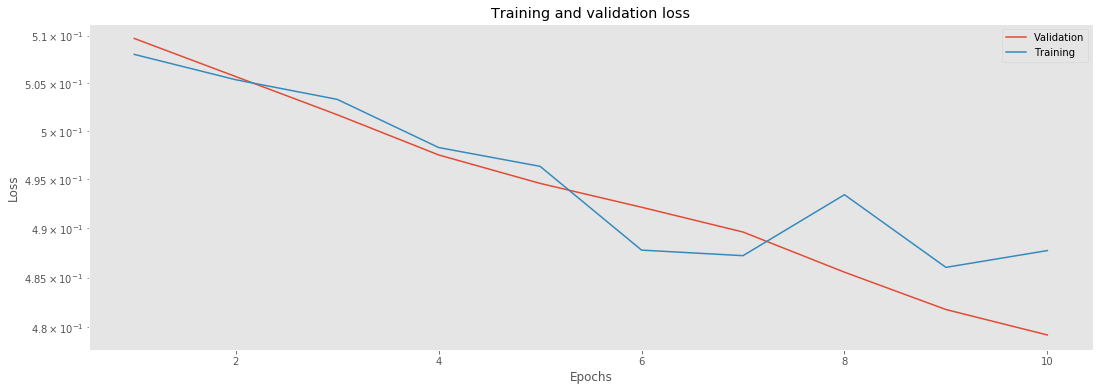

In [0]:
plot_metric(history, 'loss')

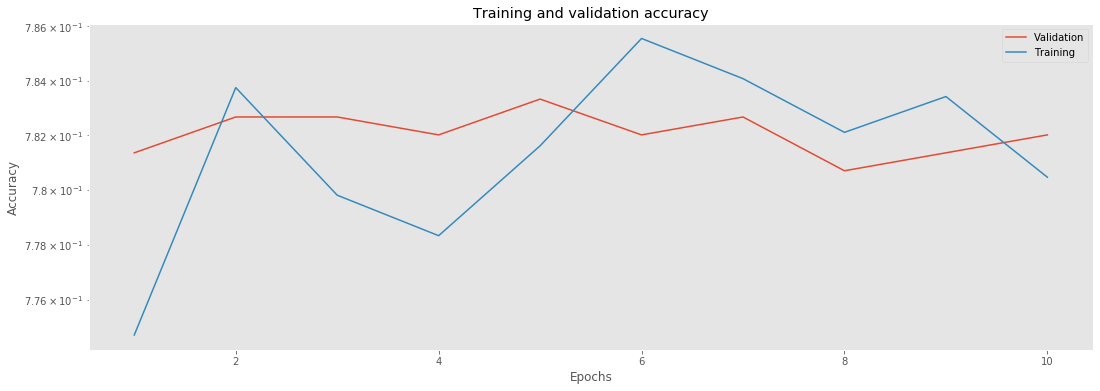

In [0]:
plot_metric(history, 'accuracy')

### BERT using tensorflow_hub

In [0]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 6.2MB/s 


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization


In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
# Load BERT from the Tensorflow Hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [0]:
X_train = df['text'][:len(train_df)]
X_test = df['text'][len(train_df):]
y_train = df['target'][:len(train_df)]

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(X_train, tokenizer, max_len=100)
test_input = bert_encode(X_test, tokenizer, max_len=100)
train_labels = y_train

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Build BERT model with my tuning
model_BERT = build_model(bert_layer, max_len=100)
model_BERT.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)


In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Train BERT model with my tuning

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = 0.2,
    callbacks=[checkpoint],
    epochs = 3, # recomended 3-5 epochs
    batch_size = 8
)

Epoch 1/3
762/762 [==============================] - 973s 1s/step - loss: 0.3821 - accuracy: 0.8404 - val_loss: 0.3979 - val_accuracy: 0.8339
Epoch 2/3
762/762 [==============================] - 899s 1s/step - loss: 0.2689 - accuracy: 0.8964 - val_loss: 0.4272 - val_accuracy: 0.8306
Epoch 3/3
762/762 [==============================] - 898s 1s/step - loss: 0.1592 - accuracy: 0.9445 - val_loss: 0.4807 - val_accuracy: 0.8280


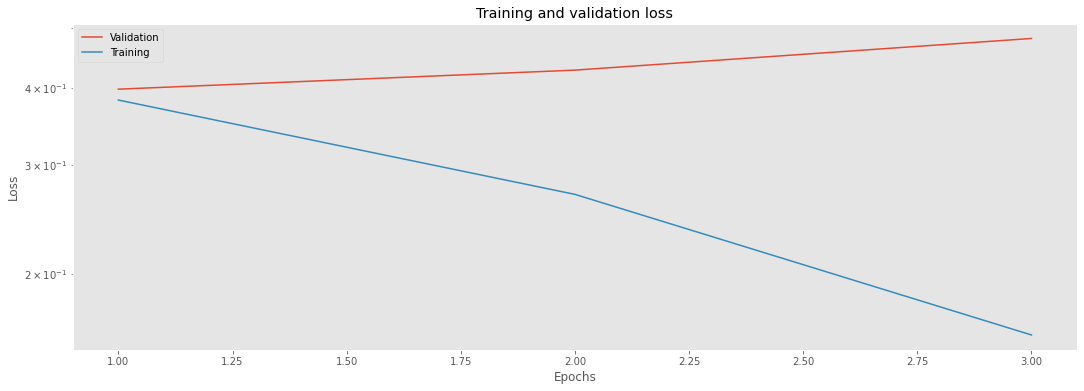

In [0]:
plot_metric(train_history, 'loss')

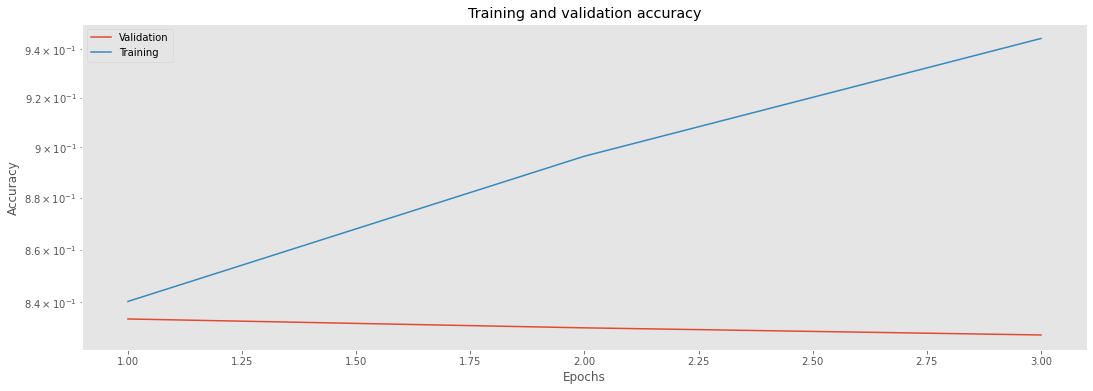

In [0]:
plot_metric(train_history, 'accuracy')

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Prediction by BERT model with my tuning
#model_BERT.load_weights('model_BERT.h5')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

In [0]:
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [0]:
submission = pd.read_csv("sample_submission.csv")
submission['target'] = test_pred_BERT_int

In [0]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
submission.to_csv("submission.csv", index=False)